In [17]:
import pandas as pd
import numpy as np
from collections import Counter
import math

def calculate_entropy(data_list):
    count = Counter(data_list)
    probabilities = [count[key] / len(data_list) for key in count.keys()]
    entropy = -sum([p * math.log2(p) for p in probabilities])
    return entropy

def preprocess_data(df):
    # Convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Convert duration columns to float (in case they're strings)
    df['flow_duration_sec'] = df['flow_duration_sec'].astype(float)
    df['flow_duration_nsec'] = df['flow_duration_nsec'].astype(float)
    
    # Calculate total flow duration in seconds
    df['total_flow_duration'] = df['flow_duration_sec'] + (df['flow_duration_nsec'] / 1e9)
    
    # Convert IP addresses to numerical format
    df['ip_src_num'] = df['ip_src'].apply(lambda x: int(''.join([bin(int(i))[2:].zfill(8) for i in x.split('.')]), 2))
    df['ip_dst_num'] = df['ip_dst'].apply(lambda x: int(''.join([bin(int(i))[2:].zfill(8) for i in x.split('.')]), 2))
    
    # Handle missing values for non-categorical columns
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    df[numeric_columns] = df[numeric_columns].fillna(0)
    
    # Handle categorical columns
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    for col in categorical_columns:
        df[col] = df[col].astype('category')
        # Add a new category for missing values if necessary
        if df[col].isnull().any():
            df[col] = df[col].cat.add_categories('Unknown').fillna('Unknown')
    
    # Encode IP protocol as categorical (if not already done)
    if 'ip_proto' not in categorical_columns:
        df['ip_proto'] = df['ip_proto'].astype('category')
    
    # Create a feature for total bytes per flow duration
    df['bytes_per_second'] = df['byte_count'] / df['total_flow_duration']
    
    # Calculate entropy features
    df['etpSrcIP'] = calculate_entropy(df['ip_src'])
    df['etpSrcP'] = calculate_entropy(df['tp_src'])
    df['etpDstP'] = calculate_entropy(df['tp_dst'])
    df['etpProtocol'] = calculate_entropy(df['ip_proto'])
    
    # Calculate total packets
    df['totalPacket'] = df['packet_count'].sum()
    
    # Normalize numerical columns
    numerical_cols = ['flow_duration_sec', 'flow_duration_nsec', 'packet_count', 'byte_count', 
                      'packet_count_per_second', 'byte_count_per_second', 'bytes_per_second',
                      'etpSrcIP', 'etpSrcP', 'etpDstP', 'etpProtocol']
    df[numerical_cols] = (df[numerical_cols] - df[numerical_cols].mean()) / df[numerical_cols].std()
    
    return df

# Load the CSV file
df = pd.read_csv('flowstatsfile.csv')
print("Lo")
# Display basic information about the dataset
print(df.info())

# Apply preprocessing
preprocessed_df = preprocess_data(df)

# Display basic information about the preprocessed dataset
print(preprocessed_df.info())

# Display the first few rows of the preprocessed data
print(preprocessed_df.head())

# Print entropy statistics
print(f"Entropy of source IP address (etpSrcIP): {preprocessed_df['etpSrcIP'].iloc[0]}")
print(f"Entropy of source port (etpSrcP): {preprocessed_df['etpSrcP'].iloc[0]}")
print(f"Entropy of destination port (etpDstP): {preprocessed_df['etpDstP'].iloc[0]}")
print(f"Entropy of packet protocol (etpProtocol): {preprocessed_df['etpProtocol'].iloc[0]}")
print(f"Total number of packets (totalPacket): {preprocessed_df['totalPacket'].iloc[0]}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2667523 entries, 0 to 2667522
Data columns (total 22 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   timestamp                 float64
 1   datapath_id               int64  
 2   flow_id                   object 
 3   ip_src                    object 
 4   tp_src                    int64  
 5   ip_dst                    object 
 6   tp_dst                    int64  
 7   ip_proto                  int64  
 8   icmp_code                 int64  
 9   icmp_type                 int64  
 10  flow_duration_sec         int64  
 11  flow_duration_nsec        int64  
 12  idle_timeout              int64  
 13  hard_timeout              int64  
 14  flags                     int64  
 15  packet_count              int64  
 16  byte_count                int64  
 17  packet_count_per_second   float64
 18  packet_count_per_nsecond  float64
 19  byte_count_per_second     float64
 20  byte_count_per_nsecond  

TypeError: Cannot setitem on a Categorical with a new category (0), set the categories first

In [9]:
import numpy as np
from collections import Counter
import math


In [10]:
import pandas as pd
import matplotlib.pyplot as plt


In [11]:
file_path = 'FlowStatsfile.csv'
df = pd.read_csv(file_path)
print("data read success")


data read success


In [12]:
df.head()


,timestamp,datapath_id,flow_id,ip_src,tp_src,ip_dst,tp_dst,ip_proto,icmp_code,icmp_type,...,idle_timeout,hard_timeout,flags,packet_count,byte_count,packet_count_per_second,packet_count_per_nsecond,byte_count_per_second,byte_count_per_nsecond,label
0,1.589933e+09,1,10.0.0.1505010.0.0.3542466,10.0.0.1,5050,10.0.0.3,54246,6,-1,-1,...,20,100,0,50776,3351216,12694.00,1.057833e-04,8.378040e+05,6.981700e-03,0
1,1.589933e+09,1,10.0.0.35424610.0.0.150506,10.0.0.3,54246,10.0.0.1,5050,6,-1,-1,...,20,100,0,209360,11834974848,52340.00,4.307819e-04,2.958744e+09,2.435180e+01,0
2,1.589933e+09,1,10.0.0.35424610.0.0.550501,10.0.0.3,54246,10.0.0.5,5050,1,0,8,...,20,100,0,3,294,0.75,6.198347e-09,7.350000e+01,6.074380e-07,0
3,1.589933e+09,1,10.0.0.55424610.0.0.350501,10.0.0.5,54246,10.0.0.3,5050,1,0,0,...,20,100,0,3,294,0.75,7.228916e-09,7.350000e+01,7.084337e-07,0
4,1.589933e+09,2,10.0.0.3010.0.0.501,10.0.0.3,0,10.0.0.5,0,1,0,8,...,20,100,0,3,294,0.75,7.092199e-09,7.350000e+01,6.950355e-07,0


In [13]:
# Check the data types and basic statistics of the numerical columns
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2667523 entries, 0 to 2667522
Data columns (total 22 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   timestamp                 float64
 1   datapath_id               int64  
 2   flow_id                   object 
 3   ip_src                    object 
 4   tp_src                    int64  
 5   ip_dst                    object 
 6   tp_dst                    int64  
 7   ip_proto                  int64  
 8   icmp_code                 int64  
 9   icmp_type                 int64  
 10  flow_duration_sec         int64  
 11  flow_duration_nsec        int64  
 12  idle_timeout              int64  
 13  hard_timeout              int64  
 14  flags                     int64  
 15  packet_count              int64  
 16  byte_count                int64  
 17  packet_count_per_second   float64
 18  packet_count_per_nsecond  float64
 19  byte_count_per_second     float64
 20  byte_count_per_nsecond  

In [14]:
print(df.describe())

          timestamp   datapath_id        tp_src        tp_dst      ip_proto  \
count  2.667523e+06  2.667523e+06  2.667523e+06  2.667523e+06  2.667523e+06   
mean   1.590023e+09  2.985793e+00  2.225254e+04  6.001862e+03  6.625404e+00   
std    5.401687e+04  1.513236e+00  2.209444e+04  1.506899e+04  6.059951e+00   
min    1.589933e+09  1.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00   
25%    1.589963e+09  2.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00   
50%    1.590011e+09  3.000000e+00  1.519800e+04  8.000000e+01  6.000000e+00   
75%    1.590072e+09  4.000000e+00  4.243300e+04  8.000000e+01  6.000000e+00   
max    1.590164e+09  6.000000e+00  6.553500e+04  6.099800e+04  1.700000e+01   

          icmp_code     icmp_type  flow_duration_sec  flow_duration_nsec  \
count  2.667523e+06  2.667523e+06       2.667523e+06        2.667523e+06   
mean  -5.473254e-01  2.118896e+00       1.592080e+01        4.967868e+08   
std    4.977554e-01  4.169818e+00       1.947373e+01        

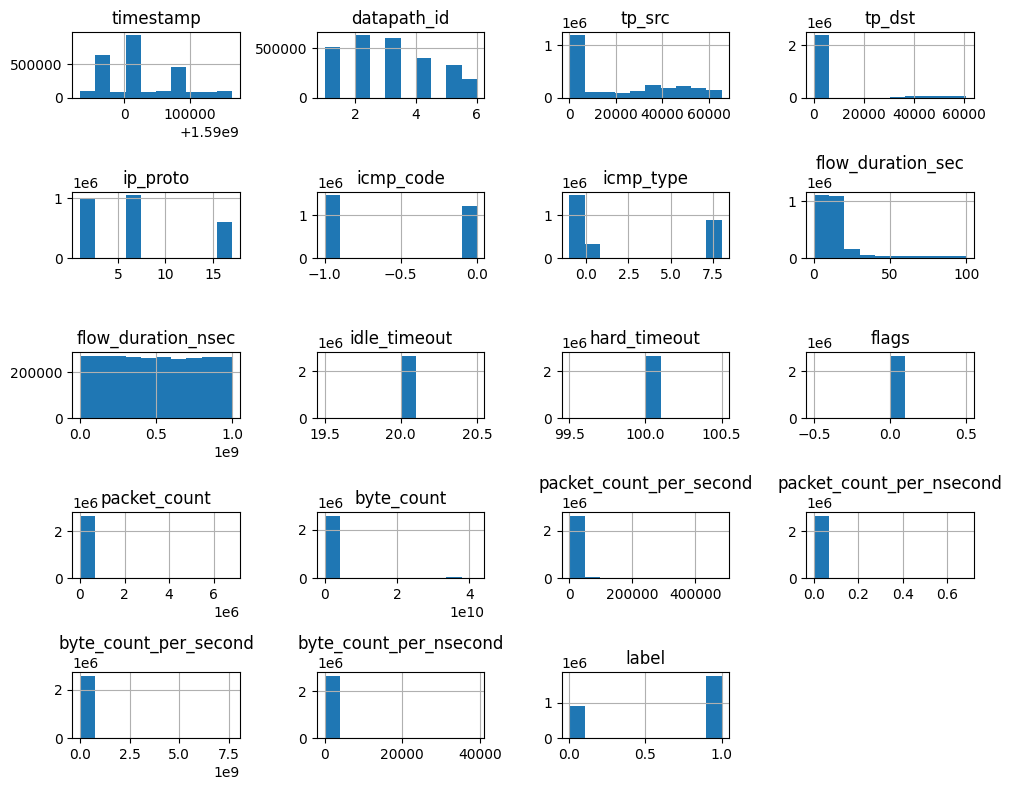

In [15]:
df.hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

In [16]:
import pandas as pd
import numpy as np
from scipy.stats import entropy

# Assuming df is your original DataFrame containing the CSV data
# If df already contains datetime format for 'timestamp', skip this line
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Resample to 1-second intervals and calculate metrics
interval_df = df.set_index('timestamp').resample('1S').agg({
    'ip_src': lambda x: entropy(np.unique(x, return_counts=True)[1]) if len(x) > 0 else np.nan,
    'tp_src': lambda x: entropy(np.unique(x, return_counts=True)[1]) if len(x) > 0 else np.nan,
    'tp_dst': lambda x: entropy(np.unique(x, return_counts=True)[1]) if len(x) > 0 else np.nan,
    'ip_proto': lambda x: entropy(np.unique(x, return_counts=True)[1]) if len(x) > 0 else np.nan,
    'packet_count': 'sum'
}).reset_index()

# Rename columns to match the specified names
interval_df.columns = ['timestamp', 'etpSrcIP', 'etpSrcP', 'etpDstP', 'etpProtocol', 'totalPacket']

# Display or further process interval_df as needed
interval_df.head()


,timestamp,etpSrcIP,etpSrcP,etpDstP,etpProtocol,totalPacket
0,1970-01-01 00:00:01,9.682949,7.51127,2.363125,1.07214,48160833215
